In [11]:
from wespeaker.cli.speaker import load_model
import torch
import torchaudio
import numpy as np


from pathlib import Path
import pandas as pd
from collections import defaultdict
import random
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Setup paths and device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PROJECT_ROOT = Path.cwd().parents[1]
DATA_DIR = PROJECT_ROOT / "data/wavs"

print("DEVICE:", DEVICE)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)



DEVICE: cuda
PROJECT_ROOT: /home/SpeakerRec/BioVoice
DATA_DIR: /home/SpeakerRec/BioVoice/data/wavs


In [12]:
speaker = load_model(PROJECT_ROOT / "wespeaker-voxceleb-resnet293-LM")
net = speaker.model
net = net.to(DEVICE)

print("ResNet-293 loaded from HF")


{'data_type': 'shard', 'dataloader_args': {'batch_size': 32, 'drop_last': True, 'num_workers': 16, 'pin_memory': False, 'prefetch_factor': 8}, 'dataset_args': {'aug_prob': 0.6, 'fbank_args': {'dither': 1.0, 'frame_length': 25, 'frame_shift': 10, 'num_mel_bins': 80}, 'num_frms': 200, 'shuffle': True, 'shuffle_args': {'shuffle_size': 2500}, 'spec_aug': False, 'spec_aug_args': {'max_f': 8, 'max_t': 10, 'num_f_mask': 1, 'num_t_mask': 1, 'prob': 0.6}, 'speed_perturb': True}, 'exp_dir': 'exp/ResNet293-TSTP-emb256-fbank80-num_frms200-aug0.6-spTrue-saFalse-ArcMargin-SGD-epoch150', 'gpus': [0, 1], 'log_batch_interval': 100, 'loss': 'CrossEntropyLoss', 'loss_args': {}, 'margin_scheduler': 'MarginScheduler', 'margin_update': {'epoch_iter': 17062, 'final_margin': 0.2, 'fix_start_epoch': 40, 'increase_start_epoch': 20, 'increase_type': 'exp', 'initial_margin': 0.0, 'update_margin': True}, 'model': 'ResNet293', 'model_args': {'embed_dim': 256, 'feat_dim': 80, 'pooling_func': 'TSTP', 'two_emb_layer':

/home/SpeakerRec/BioVoice/.venvResnet/lib/python3.10/site-packages/wespeaker/utils/checkpoint.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pa

ResNet-293 loaded from HF


In [13]:

def embed_with_resnet_293(wav_path):
    waveform, sr = torchaudio.load(wav_path)
    if sr != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(waveform)
    
    # Move waveform to the same device as the model
    waveform = waveform.to(DEVICE)
    
    # Use the speaker object's extract_embedding_from_pcm method
    embedding = speaker.extract_embedding_from_pcm(waveform, 16000)
    return embedding.squeeze()
    






In [14]:
wav_files = sorted(DATA_DIR.glob("*.wav"))

rows = []
for p in wav_files:
    stem = p.stem  # e.g. "idan_001"
    spk_name = stem.split("_")[0]
    rows.append({"file": str(p), "speaker": spk_name})

df = pd.DataFrame(rows)
print(df.head())
print("Total files:", len(df))
print("Speakers:", df["speaker"].unique())


                                               file speaker
0  /home/SpeakerRec/BioVoice/data/wavs/eden_001.wav    eden
1  /home/SpeakerRec/BioVoice/data/wavs/eden_002.wav    eden
2  /home/SpeakerRec/BioVoice/data/wavs/eden_003.wav    eden
3  /home/SpeakerRec/BioVoice/data/wavs/eden_004.wav    eden
4  /home/SpeakerRec/BioVoice/data/wavs/eden_005.wav    eden
Total files: 90
Speakers: ['eden' 'idan' 'yoav']


In [15]:
embs = []
for i, row in df.iterrows():
    vec = embed_with_resnet_293(row["file"])
    embs.append(vec)

E = np.vstack(embs).astype("float32")  # [90, 256]
print("Embedding matrix shape:", E.shape)

# L2-normalize
E_norm = E / np.linalg.norm(E, axis=1, keepdims=True)

Embedding matrix shape: (90, 256)


In [16]:
GLOBAL_ENROLL_PER_SPK = 3
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

groups = defaultdict(list)
for i, row in df.iterrows():
    groups[row["speaker"]].append(i)

enroll_idx = []
test_idx = []

for spk, idxs in groups.items():
    idxs = idxs.copy()
    random.shuffle(idxs)

    n_avail = len(idxs)
    if n_avail <= GLOBAL_ENROLL_PER_SPK:
        n_enroll = max(1, n_avail - 1)  # keep at least 1 test if we can
    else:
        n_enroll = GLOBAL_ENROLL_PER_SPK

    enroll_for_spk = idxs[:n_enroll]
    test_for_spk = idxs[n_enroll:]

    enroll_idx.extend(enroll_for_spk)
    test_idx.extend(test_for_spk)

enroll_idx = np.array(sorted(enroll_idx))
test_idx = np.array(sorted(test_idx))

print("Enrollment per speaker:", GLOBAL_ENROLL_PER_SPK)
print("Total enrollment files:", len(enroll_idx))
print("Total test files:", len(test_idx))

Enrollment per speaker: 3
Total enrollment files: 9
Total test files: 81


In [17]:
enroll_emb = E_norm[enroll_idx]
test_emb = E_norm[test_idx]

enroll_labels = df.iloc[enroll_idx]["speaker"].to_numpy()
test_labels = df.iloc[test_idx]["speaker"].to_numpy()

pred_labels = []

for e in test_emb:
    sims = cosine_similarity(e.reshape(1, -1), enroll_emb)[0]  # [N_enroll]
    best = np.argmax(sims)
    pred_labels.append(enroll_labels[best])

pred_labels = np.array(pred_labels)

accuracy = (pred_labels == test_labels).mean()
print(f"\nOverall accuracy: {accuracy:.4f}")


Overall accuracy: 1.0000


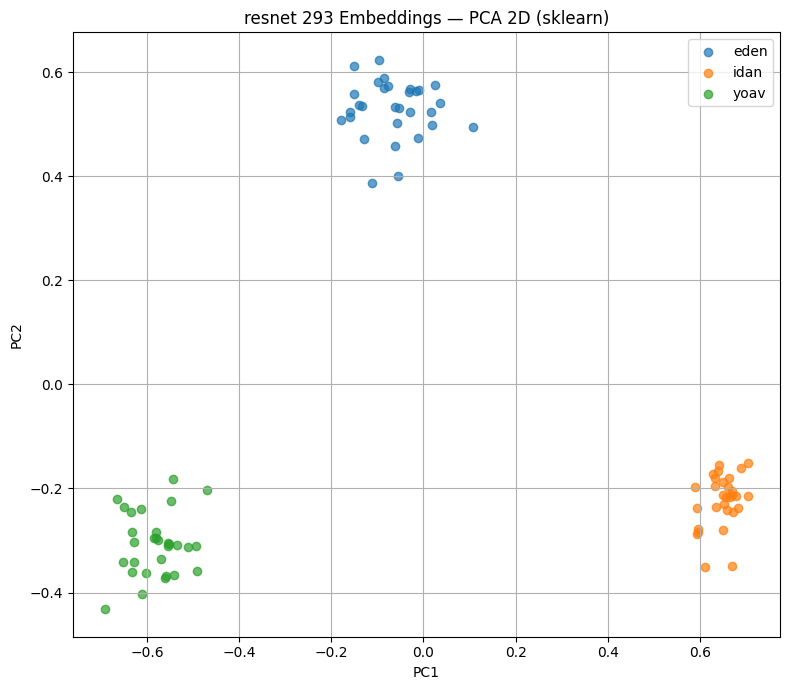

In [18]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Fit PCA on all embeddings
pca = PCA(n_components=3, random_state=0)
X_pca = pca.fit_transform(E_norm)  # shape [N, 3]

pca2d = X_pca[:, :2]  # first 2 PCs
pca3d = X_pca  # 3 PCs

speakers = df["speaker"].unique()

plt.figure(figsize=(8, 7))

for spk in speakers:
    idx = df["speaker"] == spk
    plt.scatter(pca2d[idx, 0], pca2d[idx, 1], alpha=0.7, label=spk)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("resnet 293 Embeddings — PCA 2D (sklearn)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:


OUT_ALL = Path("resnet293_all_layers.txt")
OUT_CONV = Path("resnet293_conv2d_layers.txt")

# ---- write ALL layers ----
with OUT_ALL.open("w") as f:
    for name, module in net.named_modules():
        f.write(f"{name}: {module.__class__.__name__}\n")

# ---- write ONLY Conv2D layers ----
with OUT_CONV.open("w") as f:
    for name, module in net.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            f.write(f"{name}: {module}\n")

print("Written files:")
print(OUT_ALL.resolve())
print(OUT_CONV.resolve())

Written files:
/home/SpeakerRec/BioVoice/resnet_293/poc/resnet293_all_layers.txt
/home/SpeakerRec/BioVoice/resnet_293/poc/resnet293_conv2d_layers.txt
